# Predictions for the MBTA #

## Motivation ##

TODO

## Methodology ##

### Setup ###

In [2]:
# Libraries.
import os
import itertools

import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import cross_validation, grid_search
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble

sns.set_style("whitegrid")
sns.set_context("paper")
% matplotlib inline

### Data Wrangling ###

#### MBTA ####

The MBTA provided us with entry data for each station at 15 minute intervals. After some wrangling, our base data set was composed of a ***stations*** data set and a ***gate count*** data set.

##### Stations #####

The station data set contained basic information for each station. One row corresponded to one station. Some of the data, in particular the latitude and longitude, was scraped from the web.

- ***stationid***: The unique identifier for the station.
- ***name***: The full name of the station station.
- ***line_1***: The primary line of the station (red/green/blue/orange).
- ***line_2***: The secondary line of the station (red/green/blue/orange). Only a few stations, such as park street (green/red line), had a value for this field.
- ***lat***: The latitude of the station.
- ***lon***: The longitude of the station.

In [ ]:
stations = pd.read_csv('../../../data/stations.csv', low_memory=False)
stations.head()

##### Gate Count #####

The gate count data set contained basic information for entries at each station. One row corresponded to the number of entries at a particular 15 minute interval for a station.

- ***locationid***: The unique identifier for the station.
- ***entries***: The number of entries for 15 minute interval.
- ***exits***: The number of exits for the 15 minute interval (NOT USED - exists are unreliable due to the nature of the system).
- ***service_day***: The actual day the service started (services on weekends can run into the next day).
- ***service_datetime***: The 15 minute interval where the entries/exists were aggregated.

In [ ]:
gatecounts = pd.read_csv('../../../data/gatecounts.csv', low_memory=False)
gatecounts.head()

#### Weather ####

The weather data was obtained by scraping the [wunderground](http://www.wunderground.com/) API. Each row corresponded to the weather for a single day in Boston. A sample of the data is provided below. The most important feature was the "snow_fall" column, which was the recorded snow fall for that day.

In [ ]:
weather = pd.read_csv('../../../data/weather.csv', low_memory=False)
weather.head()

#### Game Days ####

The game day data for Red Sox games was scraped directly from their website while the game day data for the Celtics and Bruines game was scraped from ESPN. Each row corresponded to a day in which a game (or games) occurred. A sample of the data is provided below. The most important features for daily prediction purposes were:

- ***bruins_game***: Binary column representing if a Bruins game occurred on this day.
- ***celtics_game***: Binary column representing if a Celtics game occurred on this day.
- ***sox_game***: Binary column representing if a Red Sox game occurred on this day.

In [ ]:
gamedays = pd.read_csv('../../../data/game_days.csv', low_memory=False)
gamedays.head()

#### Daily Data ####

The daily data set was an aggregation of entries per day for each station, with a few additional features. Sparing the details on how we generated these additional features (please refer to the ***features*** section of our repository), some important ones to recognize are:

- ***entries_weeks_ago_1***: The number of entries for this station on the same day one week ago.
- ***snow_fall***: The amount of snow the fell for that day, in inches.
- ***snow_accum***: The amount of snow accumulated up to the current day. The snow accumulation was calculated using a quasi-linear decay function based on the snow fall of the previous two weeks.
- ***dist_to_center***: The distance (in kilometers) to the center of the city (city hall).

#### Daily Data w/o Holidays ####

After some thorough analysis, we decided that "holidays" had no consistent pattern. We decided to consider them "extreme outliers" and removed them from our base data set (future analysis would be necessary for holidays). The "holidays" we removed were:

- New Years Eve
- New Years Day
- Boston Marathon
- Fourth of July
- Boston Move Out Day (September 1st)
- Thanksgiving
- Black Friday
- Christmas Week (12/25, 12/26, 12/27).

#### Daily Data w/o Weekends ####

After some thorough analysis, we decided that weekends and weekdays had two completely seperate patterns. We wanted to assist the MBTA in the greatest way possible and concentrated on weekdays, removing weekends from our base data set (future analysis would be necessary for weekends).

#### Final Data ####

Our final data set consisted of daily entries for each station, exluding holidays and weekends, with the additional weather and game features.

In [3]:
data = pd.read_csv('../../../data/mbta_daily_weather_games_grouping_noholidays_weekdays.csv', low_memory=False)
print("Rows: " + str(data.shape[0]))
print("Cols: " + str(data.shape[1]))
data = data.reset_index(drop=True)
data.head()

Rows: 31501
Cols: 53


,locationid,service_day,entries,name,line_1,line_2,lat,lon,service_datetime,fog,...,dist_to_center,entries_weeks_ago_1,entries_weeks_ago_2,entries_weeks_ago_3,bruins_game,celtics_game,sox_game,stationid,grouping,grouping_sum_weeks_ago_1
0,1002,2013-01-03 00:00:00,5733,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-03 05:00:00,0,...,3.404767,NaN,NaN,NaN,0,0,0,1002,2,33251781
1,1002,2013-01-04 00:00:00,6125,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-04 05:00:00,0,...,3.404767,NaN,NaN,NaN,0,1,0,1002,2,33251781
2,1002,2013-01-07 00:00:00,5998,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-07 04:00:00,0,...,3.404767,NaN,NaN,NaN,0,0,0,1002,2,33251781
3,1002,2013-01-08 00:00:00,6002,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-08 04:30:00,0,...,3.404767,NaN,NaN,NaN,0,0,0,1002,2,33251781
4,1002,2013-01-09 00:00:00,6055,Andrew Square,Red,NaN,42.32955,-71.05696,2013-01-09 04:45:00,0,...,3.404767,NaN,NaN,NaN,0,1,0,1002,2,33251781


##  Prediction ##

### Introduction ###

TODO

Changes in the accuracy of entry predictions are one way of determining the importance of snow to the MBTA. To do so, we can add snow "features" (or predictors) to a basic model (Linear Regression) and check for a reduction in the overall percent error of our predictions for each station. We can define percent error for each station as:

$$ \ Station \ Error = \frac{\sum^n_i{|entries_{predicted} - entries_{actual}|}}{\sum^n_i{entries_{actual}}} $$

### Method Definitions ###

The following methods are used to help us generate a prediction model and determine the percent error for each station.

In [4]:
"""
Generates a prediction model for a given station with desired features.

This will return the best model based on 10 fold cross-validation with an 70/30 train/test split.

In addition, this will return the mean absolute error for all the entries in the test set, and any outliers
based on a given absolute error threshold.

Key arguments:

  station    -- The station to train on.
  cols       -- The columns in the station data frame that are considered features.
  predictor  -- The predictor to use (sklearn predictor)
  parameters -- The parameters for the predictor.
  rstate     -- The random state to use for the train/test split.

"""
def predict(station, features, predictor, parameters, rstate):
    # Copy the station so we don't manipulate the original.
    station = station.copy()
    
    # Get the columns of the dataframe.
    all_cols = list(station.columns)
    
    # Determine the indices of the columns.
    y_col_indices = [0] + list(np.where([col == 'entries' for col in all_cols])[0] + 1)
    x_col_indices = [0] + list(np.where([col in features for col in all_cols])[0] + 1)
    
    # Make sure none of the predictor fields are null.
    for col in features:
        station = station[pd.notnull(station[col])]
    
    # Remove any entries where no one was there (probably closed) or the entries appears to be
    #  extremely low (less than 1% of the mean).
    # We assume that any entries with less than 1% of the normal entries is having serious issues.
    min_entries = np.mean(station['entries']) * .005
    station = station[station['entries'] > min_entries]
    
    # Reset the station indices, we have to reset twice so the matrix values gets the index column.
    station = station.reset_index()
    station.drop('index', axis=1, inplace=True)
    station = station.reset_index()
    
    # Get the dataframe as a matrix where the first column is the index.
    matrix = station.values
    
    # Slice so the y only contains 2 column (index, entries)
    #  and the x is a matrix that contains the index and all the predictors.
    y = matrix[:,y_col_indices]
    x = matrix[:,x_col_indices]
    
    # Split the data set into a train and test.
    x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.3, random_state=rstate)
    
    # Convert the train and test sets into a format sklean fit() expects.
    x_train_fit = np.matrix(x_train[:,1:], dtype=np.float32)
    y_train_fit = np.array([v[0] for v in y_train[:,1:]], dtype=np.uint16)
    
    x_test_fit = np.matrix(x_test[:,1:], dtype=np.float32)
    y_test_fit = np.array([v[0] for v in y_test[:,1:]], dtype=np.uint16)
    
    # Train using a grid search based on the parameters provided.
    clf = grid_search.GridSearchCV(predictor, parameters, scoring='mean_squared_error', cv=10)
    clf.fit(x_train_fit, y_train_fit)
    
    # Determine what the best model was.
    model = clf.best_estimator_
    
    # Find the train/test data sets in the original station data frame.
    train_results = station.iloc[y_train[:,0]]
    test_results = station.iloc[y_test[:,0]]
    
    # Predict using the train/test set.
    train_results['prediction'] = model.predict(x_train_fit)
    test_results['prediction'] = model.predict(x_test_fit)
    
    # Determine the percent errors.
    train_results['error'] = np.abs(train_results['prediction'] - train_results['entries']) / train_results['entries']
    test_results['error'] = np.abs(test_results['prediction'] - test_results['entries']) / test_results['entries']
    
    # Determine overall error for station for training and test.
    train_error =  np.sum(np.abs(train_results['prediction'] - train_results['entries'])) / np.sum(train_results['entries'])
    test_error =  np.sum(np.abs(test_results['prediction'] - test_results['entries'])) / np.sum(test_results['entries'])
    
    return model, train_error, test_error, train_results, test_results

In [5]:
"""
Tests a station multiple times by running the prediction method with a different
random state.

Key arguments:

  station    -- The station to test for.
  cols       -- The columns in station to use as features.
  predictor  -- The predictor to use (sklearn predictor)
  parameters -- The parameters for the predictor.
  trials     -- The number of times to run predict (also the number of randomly generated test sets).

"""
def test_station(station, cols, predictor, parameters, error_threshold = 0.2, trials = 50):
    train_errors = np.zeros(trials)
    test_errors = np.zeros(trials)
    train_outliers = pd.DataFrame()
    test_outliers = pd.DataFrame()
    
    for rstate in xrange(trials):
        model, train_error, test_error, train_results, test_results = predict(station, cols, predictor, parameters, rstate)
        
        # Keep track of the train and test errors for this result.
        train_errors[rstate] = train_error
        test_errors[rstate] = test_error
        
        # Keep track of any "outliers" for both the train and test group, i.e. rows that were above the threshold.
        trial_train_outliers = train_results[train_results['error'] > error_threshold]
        trial_test_outliers = test_results[test_results['error'] > error_threshold]
        
        if len(train_outliers) == 0 and len(test_outliers) == 0:
            train_outliers = trial_train_outliers
            test_outliers = trial_test_outliers
        else:
            train_outliers = pd.concat([train_outliers, trial_train_outliers[~trial_train_outliers.isin(train_outliers.index)]])
            test_outliers = pd.concat([test_outliers, trial_test_outliers[~trial_test_outliers.isin(test_outliers.index)]])
    
    return train_errors, test_errors, train_outliers, test_outliers

### A Simple Example ###

Lets step through a simple example of how the process works. For this simple example, we're going to predict the entries for Andrew Square.

In [5]:
andrew_square = data[data['locationid'] == 1002]
predictor = linear_model.LinearRegression()
parameters = {}

For a group of days (test set), we want to see how accruate we can predict the number of daily entries for Andrew Square using only the number of entries on the same day for the past two weeks.

E.g. If I was predicting the entries for Andrew Square on 2015-02-21, I would build a regression model only using the known entries on 2015-02-14 and 2015-02-07 as features.

The method below builds a model and predicts the entries for multiple test sets. We can than average the error for each test set to determine the mean prediction error for Andrew Square.

In [6]:
train_errors, test_errors, train_outliers, test_outliers = test_station(andrew_square, ['entries_weeks_ago_1', 'entries_weeks_ago_2'], predictor, parameters)
print("Average Percent Error for Test Sets: " + str(np.mean(test_errors)))

Average Percent Error for Test Sets: 0.061955987446


> _We can predict entries at Andrew Square with an 6% error rate._

We can also take a look at days in which the prediction model did not perform well (> 20% error).

In [7]:
test_outliers.head()

,index,locationid,service_day,entries,name,line_1,line_2,lat,lon,service_datetime,...,snow_accum_predict,dist_to_center,entries_weeks_ago_1,entries_weeks_ago_2,entries_weeks_ago_3,bruins_game,celtics_game,sox_game,prediction,error
336,336,1002,2014-05-26 00:00:00,2809,Andrew Square,Red,NaN,42.32955,-71.05696,2014-05-26 05:00:00,...,0,3.404767,6038,6215,6231,0,0,0,6161.294728,1.193412
75,75,1002,2013-05-03 00:00:00,6774,Andrew Square,Red,NaN,42.32955,-71.05696,2013-05-03 03:15:00,...,0,3.404767,6549,312,6186,0,0,0,4626.313037,0.317049
434,434,1002,2014-10-13 00:00:00,4272,Andrew Square,Red,NaN,42.32955,-71.05696,2014-10-13 05:00:00,...,0,3.404767,6716,6288,6321,1,0,0,6275.618417,0.469012
188,188,1002,2013-10-14 00:00:00,4212,Andrew Square,Red,NaN,42.32955,-71.05696,2013-10-14 04:30:00,...,0,3.404767,6385,6312,6392,1,0,0,6236.032889,0.480540
65,65,1002,2013-04-19 00:00:00,312,Andrew Square,Red,NaN,42.32955,-71.05696,2013-04-19 04:45:00,...,0,3.404767,6186,6947,6324,0,0,0,6381.087873,19.452205


### Finding the Best Feature Set ###

Determining features is generally the first step of the model generation process. For our scenario, we wanted to determine the feature set that results in the lowest possible average percent error across all stations. To accomplish this, we executed an exhaustive search of feature sets to determine which performed the best.

In [6]:
"""
Tests all stations with a set of features.

Key arguments:

  features   -- The features to test.
  preditor   -- The skleanr predictor to use.
  parameters -- The parameters to use for the predictor.
  stations   -- The stations to look at. If None is provided, it will use all stations.

"""
def test_all_stations(predictor, parameters, features, locationids = None):
    results = pd.DataFrame()
    
    if locationids == None:
        locationids = np.unique(data['locationid'])
    
    # Test the feature sets for every single station.
    for locationid in locationids:
        result = pd.Series()
        
        # Get a particular station.
        station = data[data['locationid'] == locationid]
        
        # Add identifier information.
        result['locationid'] = locationid
        result['name'] = station['name'].iloc[0]
        
        # Get the mean percent error for the train/test set using the base feature.
        train_errors, test_errors, _, _ = test_station(station, features, predictor, parameters)
        result['train_error'] = np.mean(train_errors)
        result['test_error'] = np.mean(test_errors)
        result['features'] = str(features)
        
        # Save the result.
        results = results.append(result, ignore_index=True)
    
    return results

#### Base Feature Set ####

This feature set was included in all feature combinations (consider it the baseline feature set).

In [10]:
base_features = ['entries_weeks_ago_1']

#### Additional Feature Set ####

The "additional" features we wanted to test included weather, sports, and other aspects of the data.

In [11]:
other_features = [
    'entries_weeks_ago_2', 
    'entries_weeks_ago_3',
    ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4'],
    ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
    ['temp_min', 'temp_max', 'temp_mean'],
    ['rain', 'rain_fall'],
    ['snow', 'snow_fall', 'snow_accum'],
    ['bruins_game', 'celtics_game', 'sox_game'],
]

#### Exhaustive Search ####

For all possible combinations of "other features", we determined the average percent error across all stations.

In [ ]:
results = pd.DataFrame()

# Use linear regression since it is simple and fast.
predictor = linear_model.LinearRegression()
parameters = {}

i = 0
# Try every combination of the "other features".
for l in range(0, len(other_features) + 1):
    for subset in itertools.combinations(other_features, l):
        # Add on the base line features.
        features = list(base_features)
        # Build the feature list.
        for feature in subset:
            features += [feature] if not isinstance(feature, list) else feature
        
        # Save results to disk, since this takes a while and we don't want to lose results.
        results = results.append(test_all_stations(predictor, parameters, features), ignore_index=True)
        results.to_csv("../../results/prediction/feature_set_" + str(i) + ".csv")
        i += 1

In [12]:
featureset_results = pd.read_csv("../../results/prediction/feature_set_eval.csv", low_memory=False)
featureset_results.head()

,Unnamed: 0,features,locationid,name,test_error,train_error
0,0,['entries_weeks_ago_1'],1002,Andrew Square,0.062664,0.062752
1,1,['entries_weeks_ago_1'],1004,JFK/U Mass,0.142301,0.144566
2,2,['entries_weeks_ago_1'],1005,North Quincy,0.067818,0.069260
3,3,['entries_weeks_ago_1'],1006,Wollaston,0.061919,0.062765
4,4,['entries_weeks_ago_1'],1007,Quincy Center,0.070770,0.073322


In [14]:
grouped = featureset_results.groupby('features').mean().sort('test_error')
grouped.head()

,Unnamed: 0,locationid,test_error,train_error
features,,,,
"['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']",15781,1068.126984,0.073578,0.066702
"['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'temp_min', 'temp_max', 'temp_mean', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']",16096,1068.126984,0.073932,0.066307
"['entries_weeks_ago_1', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']",15340,1068.126984,0.074003,0.067463
"['entries_weeks_ago_1', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'temp_min', 'temp_max', 'temp_mean', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']",16033,1068.126984,0.074385,0.067094
"['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']",14143,1068.126984,0.074714,0.068212


##Feature subset comparison

In [66]:
#Get scores for model runs with different feature sets
model_data = pd.read_csv("../../data/feature_set_eval.csv", low_memory=False)
model_data.head()

,Unnamed: 0,features,locationid,name,test_error,train_error
0,0,['entries_weeks_ago_1'],1002,Andrew Square,0.062664,0.062752
1,1,['entries_weeks_ago_1'],1004,JFK/U Mass,0.142301,0.144566
2,2,['entries_weeks_ago_1'],1005,North Quincy,0.067818,0.069260
3,3,['entries_weeks_ago_1'],1006,Wollaston,0.061919,0.062765
4,4,['entries_weeks_ago_1'],1007,Quincy Center,0.070770,0.073322


In [8]:
#define feataure groups to compare
target_features = ["['entries_weeks_ago_1']",
       "['entries_weeks_ago_1', 'entries_weeks_ago_2']",
       "['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3']",
       "['entries_weeks_ago_1', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4']",
       "['entries_weeks_ago_1', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']",
       "['entries_weeks_ago_1', 'snow', 'snow_fall', 'snow_accum']",
       "['entries_weeks_ago_1', 'rain', 'rain_fall']",
       "['entries_weeks_ago_1', 'temp_min', 'temp_max', 'temp_mean']",
       "['entries_weeks_ago_1', 'bruins_game', 'celtics_game', 'sox_game']",
       "['entries_weeks_ago_1', 'grouping_sum_weeks_ago_1']",
       "['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'temp_min', 'temp_max', 'temp_mean', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']",
       "['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game', 'grouping_sum_weeks_ago_1 ']"
      ] 

labels = ['baseline',
        '-w2',
        '-w2, -w3',
        'd1-d7',
        'm1-m12',
        'snow',
        'rain',
        'temp',
        'game',
        'all',
        'selected']

In [9]:
#temporary scores obtained in old scoring systems
score_f = [0.269181924004, #baseline
0.223902560054, #w2
0.236379483171, #w2 w3
0.268650658513, #d1-d7 
0.264698748367, #m1-m12
#0.253837452493,
0.242485524164, #snow fall accum
#0.268025250155,
0.269461967123, #rain
0.266342899745, #temp mean
#0.266285460861,
#0.266606974131,
#0.269181923934,
0.244569752437, #games
0.208476176623,  #all
#0.200715592655,
0.209331960565
]


In [10]:
#grab results for feature combinations of interest
subfeatures = model_data[(model_data['features'] == target_features[0])
      | (model_data['features'] == target_features[1])
      | (model_data['features'] == target_features[2])
      | (model_data['features'] == target_features[3])
      | (model_data['features'] == target_features[4])
      | (model_data['features'] == target_features[5])
      | (model_data['features'] == target_features[6])
      | (model_data['features'] == target_features[7])
      | (model_data['features'] == target_features[8])
      | (model_data['features'] == target_features[9])
      | (model_data['features'] == target_features[10])
      ]

NameError: name 'model_data' is not defined

In [70]:
#merge labels and order for graphing
feats = pd.DataFrame(target_features)
feats['label'] = labels
feats['order'] = range(1,12)
feats.columns = ['features','label','order']
#feats

In [71]:
#merge error results and label
grouped_data = subfeatures.groupby('features').mean()
grouped_data = grouped_data.reset_index()
grouped_data = pd.merge(grouped_data,feats)
grouped_data = grouped_data.sort(['order'], ascending=[1])
#grouped_data.head(n=20)

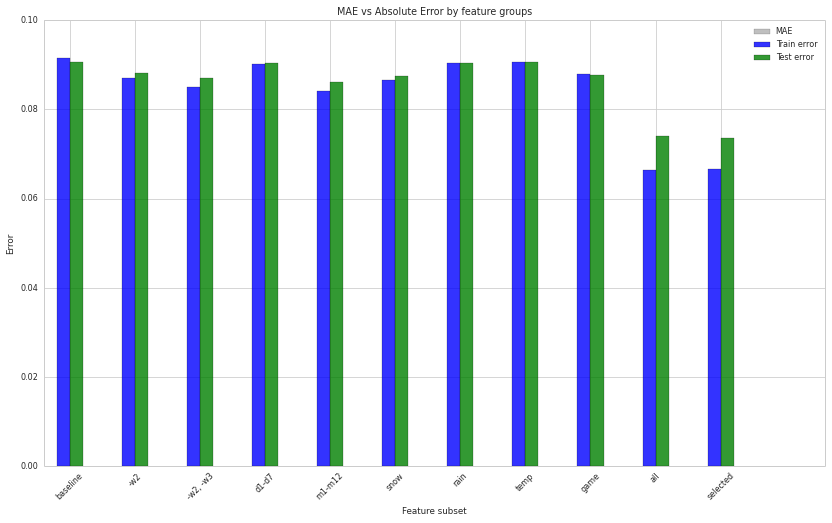

In [72]:
#plot errors for each feature subset
features = grouped_data.label
trainerror = grouped_data.train_error 
testerror = grouped_data.test_error 


ind = np.arange(len(testerror))
width = .2

fig, ax = plt.subplots(figsize=(14, 8))
#rects1 = ax.bar(ind, score_f, width, color='gray', alpha =.5)
rects2 = ax.bar(ind+width, trainerror, width, color='blue', alpha=.8)
rects3 = ax.bar(ind+2*width, testerror, width, color='green', alpha=.8)


# add some text for labels, title and axes ticks
ax.set_title('MAE vs Absolute Error by feature groups')
ax.set_xlabel('Feature subset')
ax.set_ylabel('Error')

ax.set_xticks(ind+2*width)
ax.set_xticklabels(labels, rotation=45)#, ha='right' )

ax.legend( (rects1[0], rects2[0], rects3[0]), ('MAE', 'Train error', 'Test error') )

plt.show()


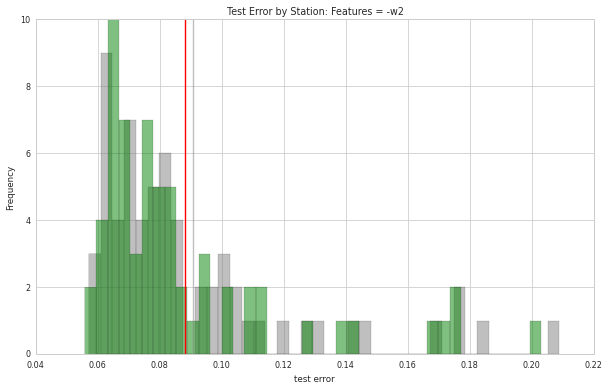

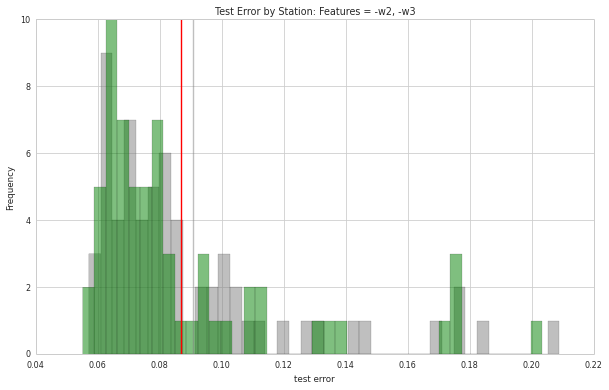

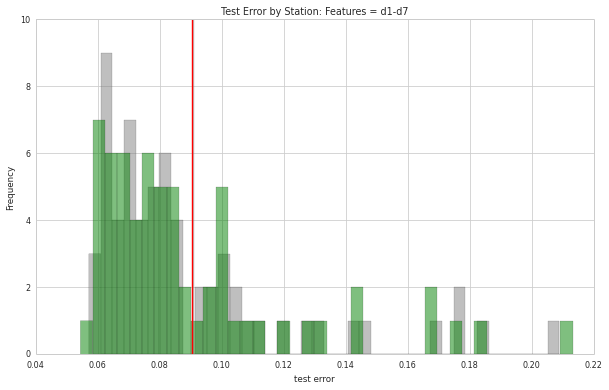

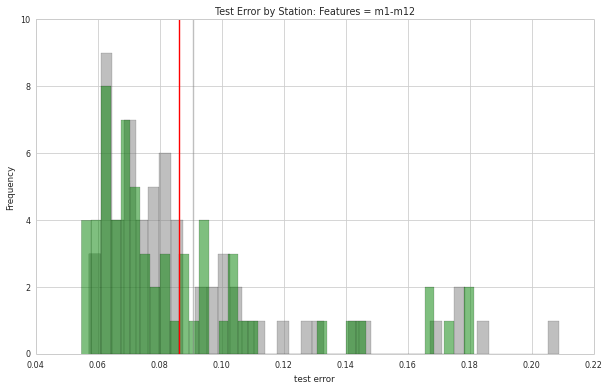

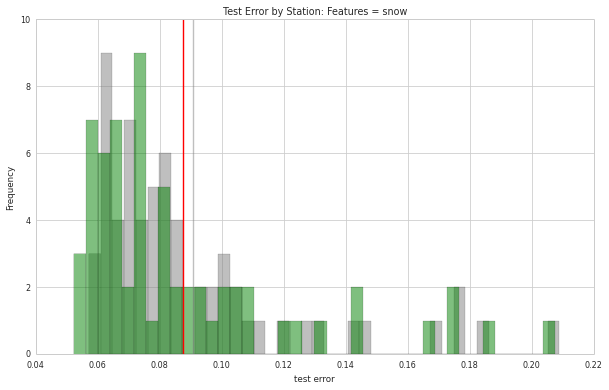

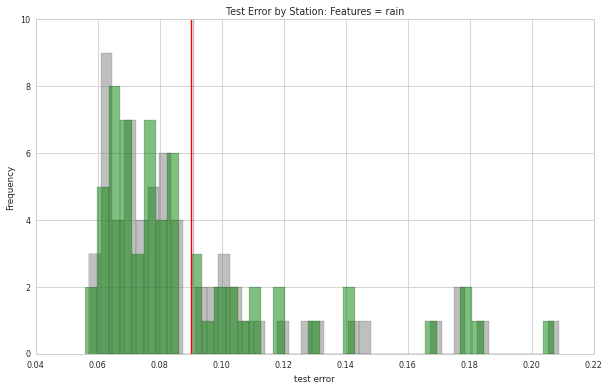

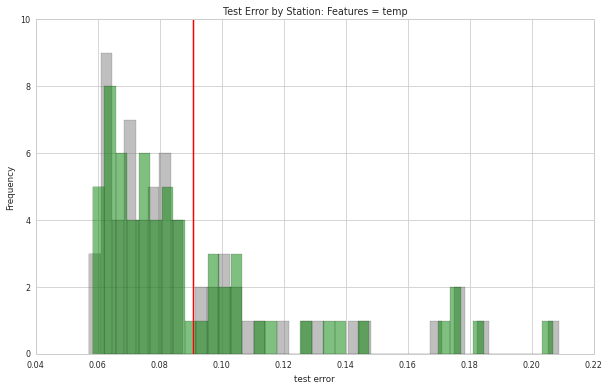

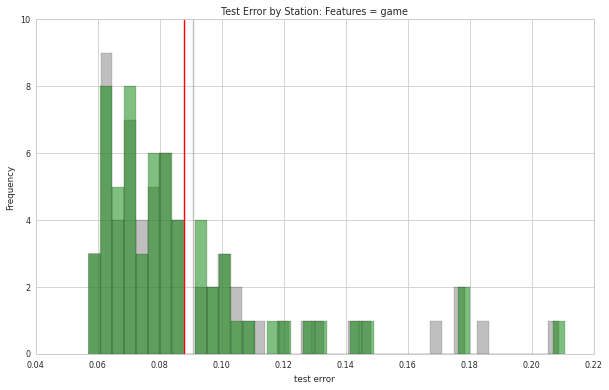

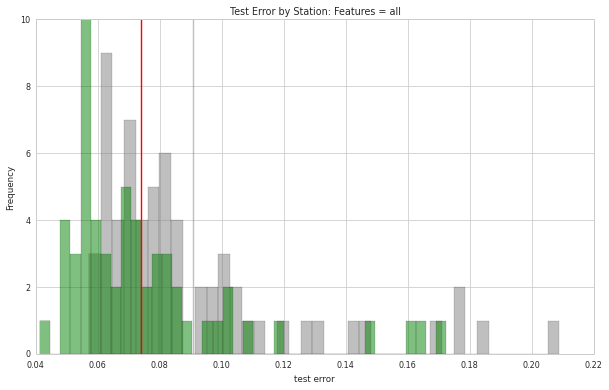

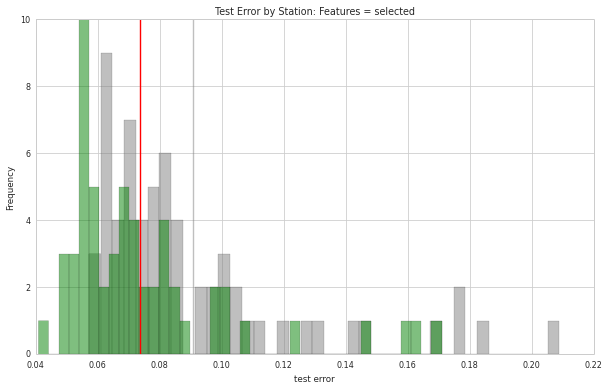

In [73]:
#plot histograms of feature subsets
baseline = model_data[model_data['features'] == target_features[0]]

for i in range(1,len(target_features)):
    
    sf = model_data[model_data['features'] == target_features[i]]
    
    # Plot distribution of entries.
    plt.figure(figsize=(10,6))
    plt.hist(baseline.test_error, bins=40, color= 'gray', alpha=.5)
    plt.hist(sf.test_error.values, bins=40, color= 'green', alpha=.5)

    plt.vlines(baseline.test_error.mean(),0,10,colors='gray', alpha=.5)
    plt.vlines(sf.test_error.mean(),0,10,colors='r')
    
    plt.title('Test Error by Station: Features = ' + labels[i])
    plt.xlabel('test error') ; plt.ylabel('Frequency')
    plt.ylim([0,10])
    
    plt.show()


##### Conclusion #####

We found the best feature set to be.

- w1
- w2
- d1-d7
- m1-m12
- snow
- gameday

train error = **0.066**	
test error = **0.07**


In [7]:
target_features =[
    ['entries_weeks_ago_1'],
    ['entries_weeks_ago_1', 'entries_weeks_ago_2'],
    ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3'],
    ['entries_weeks_ago_1', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4'],
    ['entries_weeks_ago_1', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
    ['entries_weeks_ago_1', 'snow', 'snow_fall', 'snow_accum'],
    ['entries_weeks_ago_1', 'rain', 'rain_fall'],
    ['entries_weeks_ago_1', 'temp_min', 'temp_max', 'temp_mean'],
    ['entries_weeks_ago_1', 'bruins_game', 'celtics_game', 'sox_game'],
    ['entries_weeks_ago_1', 'grouping_sum_weeks_ago_1'],
    ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'temp_min', 'temp_max', 'temp_mean', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game', 'grouping_sum_weeks_ago_1'],
    ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game'],
    ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'rain', 'rain_fall', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game', 'grouping_sum_weeks_ago_1']
] 

In [8]:
results = pd.DataFrame()

# Use linear regression since it is simple and fast.
predictor = linear_model.LinearRegression()
parameters = {}

i = 0
# Try every combination of the "other features".
for i in range(0, len(target_features)):
    features = target_features[i]
    
    results = results.append(test_all_stations(predictor, parameters, features), ignore_index=True)
    results.to_csv("../../results/prediction/target_feature_set_" + str(i) + ".csv")

### Finding the Best Model ###

The next step of the process is to determine the best algorithm (model) for prediction. We decided to test the following algorithms using the best features we determined before.

- Ridge Regression
- Random Forrest
- SVM (Support Vector Machines are often the de facto default algorithm to use for a lot of machine learning scenarios. However, based on some preliminary results we decided not to continue testing with SVMs. The time to train was not worth the trivial gain in accuracy - it was taking hours to train a single station!)

In [8]:
best_features = ['entries_weeks_ago_1', 'entries_weeks_ago_2', 'entries_weeks_ago_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'snow', 'snow_fall', 'snow_accum', 'bruins_game', 'celtics_game', 'sox_game']

In [ ]:
"""
Tests a station multiple times by running the prediction method with a different
random state and records the best parameters for each run.

Key arguments:

  station       -- The station to test for.
  predictor     -- The predictor to use (sklearn predictor)
  parameters    -- The parameters for the predictor.
  param_results -- The object to store the parameter results in.
  trials        -- The number of times to run predict (also the number of randomly generated test sets).

"""
def test_params(station, predictor, parameters, param_results, trials = 50):
    for rstate in xrange(trials):
        model, train_error, test_error, train_results, test_results = predict(station, best_features, predictor, parameters, rstate)
        
        param_results = param_results.append({'train_error': train_error, 'test_errors': test_error, 'params': str(model.get_params())}, ignore_index=True)
    
    return param_results

#### Ridge Regression ####

Ridge regression requires a magic number (alpha) that controls the amount of shrinkage (robustness to co-linear features). One approach to finding the best alpha for our environment is to run a grid search with a wide range of alphas on every station. Once the best alpha is determined, it will used as the default alpha for the final ridge regression models.

In [ ]:
param_results = pd.DataFrame()

for locationid in np.unique(data['locationid']):
    station = data[data['locationid'] == locationid]
    
    predictor = linear_model.Ridge()
    parameters = {'alpha': range(0, 101)}
    
    param_results = test_params(station, predictor, parameters, param_results)

In [ ]:
grouped = param_results.groupby('params').agg(['mean', 'count'])
grouped['test_errors'].sort('count', ascending=False).to_csv("../../results/prediction/ridge-param-results.csv", ignore_index=True)

In [15]:
predictor = linear_model.Ridge()
parameters = {'alpha': [1.0]}
ridge_regression_results = test_all_stations(predictor, parameters, best_features)

In [16]:
print(ridge_regression_results['test_error'].mean())
ridge_regression_results.head()

0.0761073602689


,features,locationid,name,test_error,train_error
0,"['entries_weeks_ago_1', 'entries_weeks_ago_2',...",1002,Andrew Square,0.051160,0.047298
1,"['entries_weeks_ago_1', 'entries_weeks_ago_2',...",1004,JFK/U Mass,0.098075,0.092778
2,"['entries_weeks_ago_1', 'entries_weeks_ago_2',...",1005,North Quincy,0.058974,0.053658
3,"['entries_weeks_ago_1', 'entries_weeks_ago_2',...",1006,Wollaston,0.050891,0.046671
4,"['entries_weeks_ago_1', 'entries_weeks_ago_2',...",1007,Quincy Center,0.058022,0.054156


##### Random Forrest #####

In [16]:
param_results = pd.DataFrame()

for locationid in np.unique(data['locationid']):
    station = data[data['locationid'] == locationid]
    
    predictor = ensemble.RandomForestRegressor()
    parameters = {'n_estimators': range(10, 20)}
    
    param_results = test_params(station, predictor, parameters, param_results)

In [17]:
grouped = param_results.groupby('params').agg(['mean', 'count'])
grouped['test_errors'].sort('count', ascending=False).head()

,mean,count
params,,
"{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 19, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}",0.075936,446
"{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 18, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}",0.075987,427
"{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 17, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}",0.077465,395
"{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 16, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}",0.077740,375
"{'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'min_density': None, 'compute_importances': None, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 15, 'min_samples_split': 2, 'random_state': None, 'criterion': 'mse', 'max_features': 'auto', 'max_depth': None}",0.074958,350


In [18]:
grouped = param_results.groupby('params').agg(['mean', 'count'])
grouped['test_errors'].sort('count', ascending=False).to_csv("../../results/prediction/randomforrest-param-results.csv", ignore_index=True)

## Conclusion ##

- *What are the most important features?*

- *What was the best model?*

- *What is the average prediction ratio?*

- *What are some known outliers?*